In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_17056/1229163428.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


## Lib Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.options.display.max_rows = 10

## Constants

### Tech Company Membership

The below lists will be used to aggregate companies based on whether they are part of the various 'FAANG' listings or not. The criteria for inclusion is based on the below wikipedia page.

https://en.wikipedia.org/wiki/Big_Tech

In [3]:
BIG_FOUR = ['Google', 'Apple', 'Amazon', 'Meta']
BIG_FIVE = ['Google', 'Amazon', 'Apple', 'Meta', 'Microsoft']
MAGNIFICANT_SEVEN = ['Google', 'Amazon', 'Apple', 'Meta', 'Microsoft', 'Nvidia', 'Tesla']
CHINESE_TECH = ['Baidu', 'Alibaba', 'Tencent', 'Xiaomi']

## Dataset Import

* Name: tech_layoffs
* Source: kaggle
* Url: https://www.kaggle.com/datasets/salimwid/technology-company-layoffs-20222023-data

In [4]:
df = pd.read_csv('tech_layoffs.csv', delimiter=';')
df.head()

,Nr.,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,1,3,ShareChat,Bengaluru,India,Asia,200.0,2023-12-20,15.0,1333.0,1133.0,Consumer,Series H,$1700,2023,12.97194,77.59369
1,2,4,InSightec,Haifa,Israel,Asia,100.0,2023-12-19,20.0,500.0,400.0,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,3,6,Enphase Energy,San Francisco Bay Area,USA,North America,350.0,2023-12-18,10.0,3500.0,3150.0,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,4,7,Udaan,Bengaluru,India,Asia,100.0,2023-12-18,10.0,1000.0,900.0,Retail,Unknown,NaN,2023,12.97194,77.59369
4,5,14,Cruise,San Francisco Bay Area,USA,North America,900.0,2023-12-14,24.0,3750.0,2850.0,Transportation,Acquired,$15000,2023,37.77493,-122.41942


In [5]:
df.columns

Index(['Nr.', '#', 'Company', 'Location_HQ', 'Country', 'Continent',
       'Laid_Off', 'Date_layoffs', 'Percentage', 'Company_Size_before_Layoffs',
       'Company_Size_after_layoffs', 'Industry', 'Stage',
       'Money_Raised_in_$_mil', 'Year', 'lat', 'lng'],
      dtype='object')

### 1.1 Data Preprocessing

First going to analyse the dtypes of the various columns.

In [6]:
df.dtypes

Nr.                        int64
#                          int64
Company                   object
Location_HQ               object
Country                   object
                          ...   
Stage                     object
Money_Raised_in_$_mil     object
Year                       int64
lat                      float64
lng                      float64
Length: 17, dtype: object

In [7]:
df.describe()

,Nr.,#,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng
count,1672.000000,1672.000000,1565.000000,1570.000000,1511.000000,1536.000000,1672.000000,1672.000000,1672.000000
mean,836.500000,2064.454545,278.387859,22.908014,3656.882859,3319.764757,2022.200957,34.347327,-59.878868
std,482.809141,1023.379865,886.840962,22.639925,21855.230097,21048.185867,1.302412,18.010614,74.139291
min,1.000000,3.000000,3.000000,0.044980,4.000000,0.000000,2020.000000,-41.286640,-123.262044
25%,418.750000,1209.750000,40.000000,9.060269,218.000000,150.000000,2022.000000,34.052230,-122.325530
50%,836.500000,2188.500000,87.000000,15.000000,553.000000,424.000000,2022.000000,37.774930,-79.398640
75%,1254.250000,2990.250000,200.000000,28.000000,1500.000000,1200.000000,2023.000000,42.358430,-0.125740
max,1672.000000,3537.000000,12000.000000,100.000000,400000.000000,392000.000000,2024.000000,60.204767,174.775570


Most of the dtypes are consistent with what I would expect to see; Laid_Off are numeric, Industry/Stage and strings and therefore represented as objects etc. I'll just analyse the distribution of the Laid_Off values, as these will be crucial in analysing the tech layoffs across Companies, Region and Sector.

### 1.2 Investigating missing columns

There is one missing value for Company, so this value will just be removed. In order to evaluate the impact of the other missing values, I will need to calculate the percentage of each column which is missing.

There seem to be quite a few missing values. These will be investigated in the next section.

In [8]:
df.isna().sum()

Nr.                       0
#                         0
Company                   1
Location_HQ               0
Country                   0
                         ..
Stage                     0
Money_Raised_in_$_mil    76
Year                      0
lat                       0
lng                       0
Length: 17, dtype: int64

In [9]:
def print_missing_percentage(df: pd.DataFrame, col_name: str) -> float:
    mask = (df[col_name].isna())
    len_missing = len(df[mask])
    len_df = len(df)
    percentage_missing = (len_missing / len_df) * 100.0
    print(f"col_name: {col_name}, missing (%): {percentage_missing}")
    return percentage_missing

In [10]:
missing_cols = ['Laid_Off', 'Percentage', 'Company_Size_before_Layoffs', 'Company_Size_after_layoffs', 'Money_Raised_in_$_mil']

In [11]:
missing_percentages = [print_missing_percentage(df, col) for col in missing_cols]

col_name: Laid_Off, missing (%): 6.399521531100478
col_name: Percentage, missing (%): 6.100478468899522
col_name: Company_Size_before_Layoffs, missing (%): 9.629186602870814
col_name: Company_Size_after_layoffs, missing (%): 8.133971291866029
col_name: Money_Raised_in_$_mil, missing (%): 4.545454545454546


Overall, I would say that the missing values to Laid_Off are the most significant, as the main goal of the dataset is to evaluate layoffs. Given this, I will most just remove these missing values, and then rerun the missing percentages to see how this has impacted to missing proportions.

In [12]:
missing_laid_off_mask = (df['Laid_Off'].isna())

In [13]:
df = df[~missing_laid_off_mask]

In [14]:
df.isna().sum()

Nr.                       0
#                         0
Company                   0
Location_HQ               0
Country                   0
                         ..
Stage                     0
Money_Raised_in_$_mil    58
Year                      0
lat                       0
lng                       0
Length: 17, dtype: int64

This has resulted in a significant change in the proportion of missing values. The Percentage, Company_Size_before_Layoffs and Company_size_after_layoffs have all basically halved. I will now recalculate the missing percentages based on the new data distribution.

In [15]:
missing_percentages = [print_missing_percentage(df, col) for col in missing_cols]

col_name: Laid_Off, missing (%): 0.0
col_name: Percentage, missing (%): 3.450479233226837
col_name: Company_Size_before_Layoffs, missing (%): 3.450479233226837
col_name: Company_Size_after_layoffs, missing (%): 3.386581469648562
col_name: Money_Raised_in_$_mil, missing (%): 3.706070287539936


The missing percentages are now around 3%, which is acceptable for removal. However, it is worth analysing these missing datasets to better understand what might be the cuase. My hunch is that the majority of missing data for Percentage and Company_Size will be accounted for by startups, as established companies need to report this data to shareholders.

Based on this, I will created a mask in an attempt to separate between these types of companies.

In [16]:
missing_data_mask = ((df['Percentage'].isna()) | (df['Company_Size_before_Layoffs'].isna()) 
                     | (df['Company_Size_after_layoffs'].isna()))

In [17]:
missing_data_df = df[missing_data_mask]
missing_data_df

,Nr.,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
1408,1409,3274,Orbotech,Yavne,Israel,Asia,100.0,2024-03-19,NaN,NaN,0.0,Manufact…,Acquired,NaN,2024,31.876886,34.738297
1411,1412,3277,Flock Freight,San Diego,USA,North America,54.0,2024-03-16,NaN,NaN,NaN,Logistics,Series D,$399,2024,32.715710,-117.164720
1412,1413,3278,Chipper Cash,San Francisco Bay Area,USA,North America,20.0,2024-03-15,NaN,NaN,NaN,Finance,Series C,$302,2024,37.774930,-122.419420
1444,1445,3310,PropertyGuru,Singapore,Singapore,Asia,79.0,2024-02-27,NaN,NaN,NaN,Real Estate,Post-IPO,$676,2024,1.289670,103.850070
1447,1448,3313,WayCool,Chennai,India,Asia,70.0,2024-02-26,NaN,NaN,NaN,Food,Unknown,$363,2024,13.087840,80.278470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,1655,3520,Solarisbank,Berlin,Germany,Europe,20.0,2023-12-14,NaN,NaN,NaN,Finance,Unknown,$385,2024,52.524370,13.410530
1662,1663,3528,Analog Devices,San Francisco Bay Area,USA,North America,111.0,2023-12-13,NaN,NaN,NaN,Manufact…,Post-IPO,NaN,2024,37.336166,-121.890591
1663,1664,3529,ForgeRock,San Francisco Bay Area,USA,North America,109.0,2023-12-13,NaN,NaN,NaN,Other,Acquired,$234,2024,37.774930,-122.419420
1664,1665,3530,Flex,San Francisco Bay Area,USA,North America,31.0,2023-12-13,NaN,NaN,NaN,Manufact…,Unknown,NaN,2024,37.774930,-122.419420


In [18]:
print(f"Length of missing data: {len(missing_data_df)}")

Length of missing data: 54


In [19]:
missing_data_df['Company'].unique()

array(['Orbotech', 'Flock Freight', 'Chipper Cash', 'PropertyGuru',
       'WayCool', 'Redesign Health', 'Carbon Health', 'Affirm', 'Aptiv',
       'Pure Storage', 'Grammarly', 'Amazon', 'BillGO', 'Illumina',
       'Trove Recommer…', 'CircleCI', 'Thinx', 'TechCrunch',
       'DispatchHealth', 'Microsoft', 'Amperity', 'Personio', 'Cure.fit',
       'GoStudent', 'GoTo', 'Seedr', 'Xendit', 'TikTok', 'YouTube',
       'Sirplus', 'Veeam', 'GrabCAD', 'New Work SE', 'Cloudflare',
       'Google', 'IAC', 'Beam Benefits', 'Instagram', 'Branch',
       'Uber Freight', 'The Messenger', 'Paytm', 'Intel', 'Checkout.com',
       'Arm Holdings', 'eBay', 'Glowforge', 'Solarisbank',
       'Analog Devices', 'ForgeRock', 'Flex', 'TomTom'], dtype=object)

It looks like my initial theory was incorrect, as there seem to be alot of established companies (Instagram, Google, Microsoft) in the above list. On further reflection, it could be the case that the dataset is not up to date, as all of the entries which have missing values are from with last 3-4 months (December 2023 onwards). I will create a mask which filters the dataset based on the earliest entry in these missing values, to determine whether this is the case.

In [20]:
earliest_date = min(missing_data_df['Date_layoffs'])
earliest_date

'2023-12-12'

So the earliest entry in this missing dataset is 12/12/2023, so I will filter the original dataset based on this to determine if there is still missing data.

In [21]:
date_mask = (df['Date_layoffs'] < earliest_date)

In [22]:
filtered_df = df[date_mask]
filtered_df.isna().sum()

Nr.                       0
#                         0
Company                   0
Location_HQ               0
Country                   0
                         ..
Stage                     0
Money_Raised_in_$_mil    38
Year                      0
lat                       0
lng                       0
Length: 17, dtype: int64

Money_raised is now the only column which has missing values. I will take a quick look at the distribution of these missing entries.

In [23]:
filtered_df[filtered_df['Money_Raised_in_$_mil'].isna()]

,Nr.,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
11,12,38,Navan,San Francisco Bay Area,USA,North America,145.0,2023-12-05,5.0,2900.0,2755.0,Finance,Unknown,NaN,2023,37.44188,-122.14302
49,50,200,Epic Games,Raleigh,USA,North America,870.0,2023-09-28,16.0,5438.0,4568.0,Consumer,Unknown,NaN,2023,35.77210,-78.63861
73,74,276,Zebra Technologies,Chicago,USA,North America,700.0,2023-08-28,7.0,10000.0,9300.0,Manufacturing,Post-IPO,NaN,2023,41.85003,-87.65005
90,91,342,Discord,San Francisco Bay Area,USA,North America,37.0,2023-08-03,4.0,925.0,888.0,Consumer,Series H,NaN,2023,37.77493,-122.41942
124,125,456,FNZ,London,United Kingdom,Europe,1000.0,2023-07-06,15.0,6667.0,5667.0,Finance,Private Equity …,NaN,2023,51.50853,-0.12574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,1110,2745,Uber,Amsterdam,Netherlands,Europe,225.0,2020-06-12,25.0,900.0,675.0,Transportation,Post-IPO,NaN,2020,52.37403,4.88969
1214,1215,2919,Oscar Health,New York City,USA,North America,70.0,2020-04-23,5.0,1400.0,1330.0,Healthcare,Unknown,NaN,2020,40.71427,-74.00597
1255,1256,2997,Groupon,Chicago,USA,North America,2800.0,2020-04-13,44.0,6364.0,3564.0,Retail,Post-IPO,NaN,2020,41.85003,-87.65005
1359,1360,3183,OneWeb,London,United Kingdom,Europe,451.0,2020-03-27,85.0,531.0,80.0,Aerospace,Unknown,NaN,2020,51.50853,-0.12574


Overall, I don't think that this is an important feature, so will just remove it.

So to summarise, the below filtering will be applied to the dataframe to resolve missing entries:

* 1. Filter entries prior to 12/12/2023
* 2. Remove any missing Money_raised columns

In [24]:
earliest_date = min(missing_data_df['Date_layoffs'])
to_remove_mask = ((df['Date_layoffs'] < earliest_date) & (~df['Money_Raised_in_$_mil'].isna()))

In [25]:
df = df[to_remove_mask]
df.isna().sum()

Nr.                      0
#                        0
Company                  0
Location_HQ              0
Country                  0
                        ..
Stage                    0
Money_Raised_in_$_mil    0
Year                     0
lat                      0
lng                      0
Length: 17, dtype: int64

In [26]:
df.head()

,Nr.,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
8,9,27,Chipper Cash,San Francisco Bay Area,USA,North America,15.0,2023-12-11,33.0,45.0,30.0,Finance,Series C,$302,2023,37.77493,-122.41942
9,10,31,Zulily,Seattle,USA,North America,839.0,2023-12-08,100.0,839.0,0.0,Retail,Acquired,$194,2023,47.60621,-122.33207
10,11,37,ZestMoney,Bengaluru,India,Asia,150.0,2023-12-05,100.0,150.0,0.0,Finance,Series C,$120,2023,12.97194,77.59369
12,13,39,Incredibuild,Tel Aviv,Israel,Asia,40.0,2023-12-05,20.0,200.0,160.0,Product,Series B,$35,2023,32.08088,34.78057
13,14,44,Spotify,Stockholm,Sweden,Europe,1500.0,2023-12-04,17.0,9200.0,7700.0,Media,Post-IPO,$2100,2023,59.32938,18.06871


In [27]:
len(df)

1357

### 1.4 Feature Engineering

The next step is to start adding columns for aggregating layoffs by company. There are certain companies that have multiple instances of layoffs, so these need to be aggregated.

In [28]:
df['Total_Laid_Off'] = df.groupby('Company')['Laid_Off'].transform('sum')

It will also be worth adding column 'Num_Layoffs', which represents how many times a company had layoffs during the time period.

In [29]:
df['Num_Layoffs'] = df.groupby(['Company'])['Location_HQ'].transform('count')

Finally I will add a categorical flag 'Is_Fang' to help differentiate between FAANG and non *FAANG companies.

*I will use the combined lists for MAGNIFICANT_SEVEN and CHINESE_TECH defined at the start of this workbook.*

In [30]:
full_faang_companies = MAGNIFICANT_SEVEN + CHINESE_TECH
df['FAANG'] = df.apply(lambda x: x['Company'] in full_faang_companies, axis=1)
df.head()

,Nr.,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng,Total_Laid_Off,Num_Layoffs,FAANG
8,9,27,Chipper Cash,San Francisco Bay Area,USA,North America,15.0,2023-12-11,33.0,45.0,30.0,Finance,Series C,$302,2023,37.77493,-122.41942,180.0,4,False
9,10,31,Zulily,Seattle,USA,North America,839.0,2023-12-08,100.0,839.0,0.0,Retail,Acquired,$194,2023,47.60621,-122.33207,839.0,1,False
10,11,37,ZestMoney,Bengaluru,India,Asia,150.0,2023-12-05,100.0,150.0,0.0,Finance,Series C,$120,2023,12.97194,77.59369,250.0,2,False
12,13,39,Incredibuild,Tel Aviv,Israel,Asia,40.0,2023-12-05,20.0,200.0,160.0,Product,Series B,$35,2023,32.08088,34.78057,40.0,1,False
13,14,44,Spotify,Stockholm,Sweden,Europe,1500.0,2023-12-04,17.0,9200.0,7700.0,Media,Post-IPO,$2100,2023,59.32938,18.06871,2300.0,3,False


Now I will aggregate the columns so that only unique company entries are contained.

In [31]:
agg_dict = {colname: 'first' for colname in df.columns}
df = df.groupby('Company', as_index=False).agg(agg_dict)

Now I will reorder the columns.

In [32]:
cur_columns = df.columns.to_list()
laid_off_index = cur_columns.index('Laid_Off')
new_columns = cur_columns[: laid_off_index] + cur_columns[-3:] + cur_columns[laid_off_index + 1: -3]
assert(len(cur_columns) - 1 == len(new_columns))

In [33]:
df = df[new_columns]
df.head()

,Nr.,#,Company,Location_HQ,Country,Continent,Total_Laid_Off,Num_Layoffs,FAANG,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,385,1123,#Paid,Toronto,Canada,North America,19.0,1,False,2023-01-27,17.0,112.0,93.0,Marketing,Series B,$21,2023,43.70643,-79.39864
1,568,1582,&Open,Dublin,Ireland,Europe,9.0,1,False,2022-11-17,9.0,100.0,91.0,Marketing,Series A,$35,2022,53.33306,-6.24889
2,778,2051,10X Genomics,San Francisco Bay Area,USA,North America,100.0,1,False,2022-08-04,8.0,1250.0,1150.0,Healthcare,Post-IPO,$242,2022,37.66243,-121.87468
3,1321,3107,1stdibs,New York City,USA,North America,70.0,1,False,2020-04-02,17.0,412.0,342.0,Retail,Series D,$253,2020,40.71427,-74.00597
4,89,332,23andMe,San Francisco Bay Area,USA,North America,146.0,2,False,2023-08-08,11.0,645.0,574.0,Healthcare,Post-IPO,$1100,2023,37.77493,-122.41942


## 2. Data Analysis

For starters, I will analyse the distribution of Laid_Off and do some groupings based on Company and Region to analyse the distribution of layoffs based on these filters.


### 2.1 General Analysis

In [34]:
df.head()

,Nr.,#,Company,Location_HQ,Country,Continent,Total_Laid_Off,Num_Layoffs,FAANG,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,385,1123,#Paid,Toronto,Canada,North America,19.0,1,False,2023-01-27,17.0,112.0,93.0,Marketing,Series B,$21,2023,43.70643,-79.39864
1,568,1582,&Open,Dublin,Ireland,Europe,9.0,1,False,2022-11-17,9.0,100.0,91.0,Marketing,Series A,$35,2022,53.33306,-6.24889
2,778,2051,10X Genomics,San Francisco Bay Area,USA,North America,100.0,1,False,2022-08-04,8.0,1250.0,1150.0,Healthcare,Post-IPO,$242,2022,37.66243,-121.87468
3,1321,3107,1stdibs,New York City,USA,North America,70.0,1,False,2020-04-02,17.0,412.0,342.0,Retail,Series D,$253,2020,40.71427,-74.00597
4,89,332,23andMe,San Francisco Bay Area,USA,North America,146.0,2,False,2023-08-08,11.0,645.0,574.0,Healthcare,Post-IPO,$1100,2023,37.77493,-122.41942


In [35]:
df.dtypes

Nr.                        int64
#                          int64
Company                   object
Location_HQ               object
Country                   object
                          ...   
Stage                     object
Money_Raised_in_$_mil     object
Year                       int64
lat                      float64
lng                      float64
Length: 19, dtype: object

### 2.2 Analysing distribution of Laid_Off

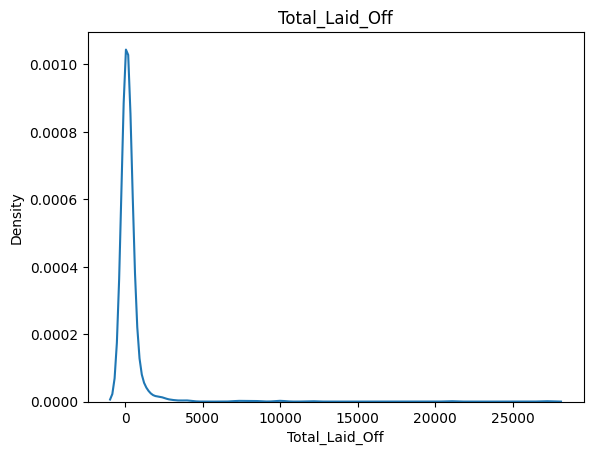

In [36]:
sns.kdeplot(x=df['Total_Laid_Off'])
plt.title('Total_Laid_Off')
plt.show()

The above plot indicates that there is a significant positive skew within the Laid_Off dataset, which is expected as the majority of layoffs were accounted for by the larger tech companies.

### 2.3 Analysing Top 10 Layoffs

In [37]:
top_count = 10
top_n_by_laid_off = df.sort_values('Total_Laid_Off', ascending=False).head(top_count)

In [38]:
top_n_by_laid_off.head(top_count)

,Nr.,#,Company,Location_HQ,Country,Continent,Total_Laid_Off,Num_Layoffs,FAANG,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
39,270,829,Amazon,Seattle,USA,North America,27150.0,4,True,2023-03-20,2.295918,392000.0,383000.0,Retail,Post-IPO,$108,2023,47.60621,-122.33207
589,279,846,Meta,San Francisco Bay Area,USA,North America,21000.0,2,True,2023-03-14,13.584117,73615.0,63615.0,Consumer,Post-IPO,$26000,2023,37.45383,-122.18219
396,403,1171,Google,San Francisco Bay Area,USA,North America,12000.0,1,True,2023-01-20,6.000000,200000.0,188000.0,Consumer,Post-IPO,$26,2023,37.38605,-122.08385
594,413,1204,Microsoft,Seattle,USA,North America,10000.0,1,True,2023-01-18,5.000000,200000.0,190000.0,Other,Post-IPO,$1,2023,47.60621,-122.33207
792,471,1347,SaleSan Franciscoorce,San Francisco Bay Area,USA,North America,10000.0,3,False,2023-01-04,10.000000,80000.0,72000.0,Sales,Post-IPO,$65,2023,37.77493,-122.41942
313,308,916,Ericsson,Stockholm,Sweden,Europe,8500.0,1,False,2023-02-24,8.000000,106250.0,97750.0,Other,Post-IPO,$663,2023,59.32938,18.06871
344,177,604,Flink,Berlin,Germany,Europe,8100.0,2,False,2023-05-24,16.000000,625.0,525.0,Food,Series B,$1000,2023,52.52437,13.41053
969,138,504,Uber,San Francisco Bay Area,USA,North America,7500.0,4,False,2023-06-21,0.996165,20077.0,19877.0,Transportation,Post-IPO,$25200,2023,37.77493,-122.41942
593,316,953,Micron,Boise,USA,North America,7200.0,2,False,2023-02-17,5.000000,48000.0,45600.0,Hardware,Post-IPO,$50,2023,43.61350,-116.20345
196,570,1587,Cisco,San Francisco Bay Area,USA,North America,4100.0,1,False,2022-11-16,5.000000,82000.0,77900.0,Infrastructure,Post-IPO,$2,2022,37.33939,-121.89496


In [39]:
top_n_by_laid_off.describe()

,Nr.,#,Total_Laid_Off,Num_Layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,334.500000,996.100000,11555.00000,2.100000,7.187620,120256.700000,113826.700000,2022.900000,43.840880,-94.038819
std,131.930327,333.456127,7068.72808,1.197219,4.774620,116231.076515,113478.776846,0.316228,7.760469,57.899532
min,138.000000,504.000000,4100.00000,1.000000,0.996165,625.000000,525.000000,2022.000000,37.339390,-122.419420
25%,272.250000,833.250000,7650.00000,1.000000,5.000000,54403.750000,50103.750000,2023.000000,37.534105,-122.332070
50%,312.000000,934.500000,9250.00000,2.000000,5.500000,81000.000000,74950.000000,2023.000000,40.694215,-122.133020
75%,410.500000,1195.750000,11500.00000,2.750000,9.500000,176562.500000,165437.500000,2023.000000,47.606210,-117.626328
max,570.000000,1587.000000,27150.00000,4.000000,16.000000,392000.000000,383000.000000,2023.000000,59.329380,18.068710


I will now drill down into some of the important trends in this breakdown.

#### Layoffs by Company

The next step is to analyze layoffs by company. I will be using the top 10 dataframe created in the previous section as there are too many company names to clearly distinguish against.

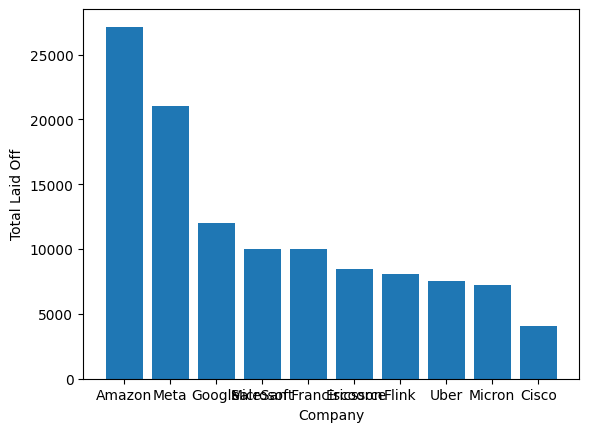

In [40]:
fig = plt.bar(top_n_by_laid_off['Company'],
              top_n_by_laid_off['Total_Laid_Off'])
plt.xlabel('Company')
plt.ylabel('Total Laid Off')
plt.show()

I will also analyse the distribution of Total_Laid_Off values be differentiating between FAANG and None FAANG Companies.

/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='FAANG', ylabel='Total_Laid_Off'>

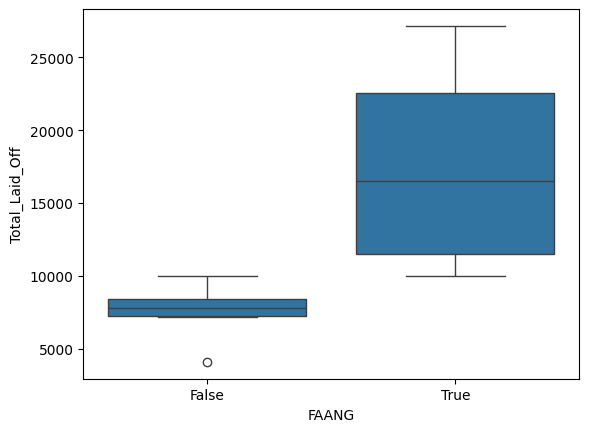

In [41]:
sns.boxplot(y=top_n_by_laid_off['Total_Laid_Off'],
            x=top_n_by_laid_off['FAANG'])

The above analysis clearly shows that American FAANG companies seem to represent the highest concentration within the Top 10 Highest layoffs within this dataset.

#### Top 10 Layoffs by Country

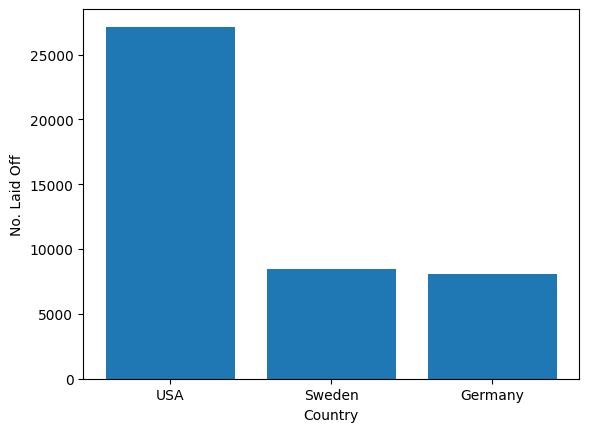

In [42]:
fig = plt.bar(top_n_by_laid_off['Country'],
              top_n_by_laid_off['Total_Laid_Off'])
plt.xlabel('Country')
plt.ylabel('No. Laid Off')
plt.show()

/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='Country', ylabel='Total_Laid_Off'>

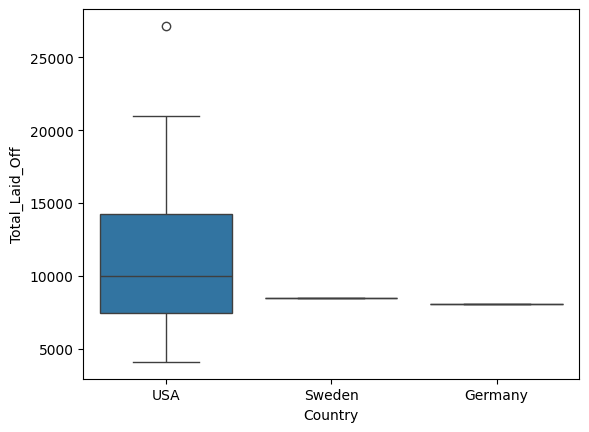

In [43]:
sns.boxplot(x=top_n_by_laid_off['Country'],
            y=top_n_by_laid_off['Total_Laid_Off'])

The above plots indicate that United States represents the Country with the highest proportion of Total_Laid_Off.

### 2.4 Analyzing Total_Laid_Off by company stage

It is also worth reviewing how the distribution of Total_Laid_Off changes across Post-IPO and prior. For this section, I will be using the entire dataframe as opposed to the top 10.

/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='Total_Laid_Off', ylabel='Stage'>

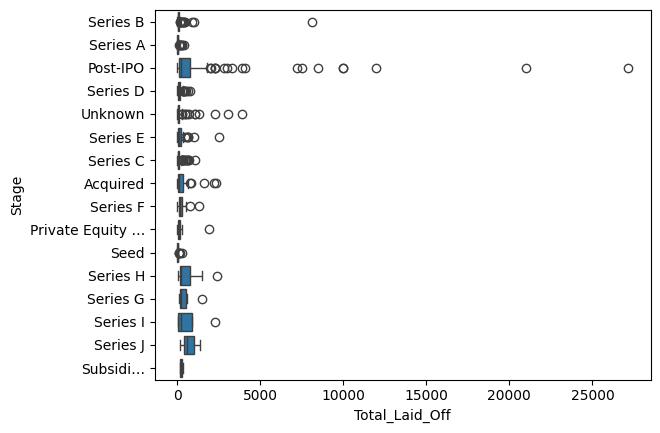

In [44]:
sns.boxplot(y=df['Stage'], x=df['Total_Laid_Off'])

One noticable trend in this boxplot is that Post-IPO has a larger proportion of extreme outliers compared to the other stages. However, there are some issues with the categorization within this dataset.

- First of all there are quite a few companies which are categorized as 'unknown'.
- Funding information can be very opaque, and there is very little that helps to distinguish between Series D and Series E that is useful.

Overall, the categorization for Stage needs to be improved before it can be used to statistical testing.

## 3. Formulating Hypothesis

Based on reporting and understanding of Tech Layoffs over the last few years, my initial hypothesis is below:

* 1. American mean Total_Laid_Off is higher than non-American Total_Laid_Off.
* 2. FAANG Company Total_Laid_Off is higher than non-FAANG Company Total_Laid_Off.

## 4. Significance Testing

We will be using a significance level of 5% for hypothesis testing.

In [45]:
ALPHA = 0.05

In [46]:
def print_significant_test_conclusion(p_value: float, alpha: float):
    """_summary_

    Args:
        p_value (float): _description_
        alpha (float): _description_
    """
    if p_value < alpha:
        print("Reject the null hypothesis.")
        print(f"p_value {p_value} is less than alpha {alpha}.")
    else:
        print("Fail to reject the null hypothesis.")
        print(F"p_value {p_value} is greater than or equal to alpha {alpha}.")
        

### 4.2 Significance Testing Hypothesis 1

$ 𝐻_{0}:\mu_{1}<=\mu_{2} $ American mean Total_Laid_Off is less than equal to rest of world.
$ 𝐻_{A}:\mu_{1}>\mu_{2} $ American mean Total_Laid_Off is not less that equal to rest of world.

#### t-test for American and non-American companies

In [47]:
american_company_mask = (df['Country'] == 'USA')

In [48]:
american_companies = df[american_company_mask]['Total_Laid_Off']
non_american_companies = df[~american_company_mask]['Total_Laid_Off']

In [49]:
t_val2, p_val2 = stats.ttest_ind(american_companies, non_american_companies)
print(f"t_value2 = {t_val2}, p_value2 = {p_val2}")

t_value2 = 1.6583589984271383, p_value2 = 0.0975324771003204


In [50]:
print_significant_test_conclusion(p_val2, t_val2)

Reject the null hypothesis.
p_value 0.0975324771003204 is less than alpha 1.6583589984271383.


#### Given the above results, we are able to reject the null hypothesis and conclude that the mean Total_Laid_Off values for American companies is higher than that of non-American companies

## Conclusion

Overall, the above results allow us toconclude that American companies contributed the largest proportion of tech layoffs within this dataset. It is also clear that FAANG + CHINESE_FAANG represented the higher proportion of tech layoffs compared to companies not in this category. However, due to the higher distribution of non FAANG companies, this was not statistically tested.

## Next Steps

I have outlined the next steps to build on this EDA further:

- Increase sample size: it would be worthwhile going back further than 2020 to see whether the distribution of tech layoffs was different. It would also be worth reviewing this analysis at a later stage to see if the lay-offs from 2024 become available.
- Improve Stage categorization: it is definitely worth looking at ways to improve this categorization, as it would help to further break up companies beyond geographical differentitation. As the box plots demonstrated, there are quite a few significant outliers within the American region, so looking at other ways of categorizing companies may help to resolve this.